# Title

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

os.chdir("../../")

## LCA Data Cleaning

In [137]:
lca_data_raw = pd.read_csv( "shared_data/oflc_performance_data/processed/LCA_long.csv" , low_memory=False)
# Number of rows
n_rows = len(lca_data_raw)
lca_data_raw.head()

,TOTAL_WORKERS,EMPLOYER_STATE,DECISION_DATE,UNIT_OF_PAY,WORKSITE_STATE,EMPLOYER_POSTAL_CODE,WORKSITE_ADDRESS1,CASE_STATUS,CASE_NUMBER,EMPLOYER_NAME,NAICS_CODE,EMPLOYER_CITY,WORKSITE_CITY,WAGE_RATE_FROM,WORKSITE_POSTAL_CODE,SOC_CODE,JOB_TITLE,EMPLOYER_ADDRESS,WAGE_RATE_TO,PROGRAM
0,1.0,MD,10-01-09,Year,GA,21045.0,NaN,CERTIFIED-WITHDRAWN,I-200-09198-587210,XPEDITE TECHNOLOGIES INC,541511.0,COLUMBIA,ATLANTA,51022.00,NaN,15-1071.00,NETWORK AND COMPUTER SYSTEMS ADMINISTRATORS,8830 STANFORD BLVD,NaN,LCA
1,1.0,NJ,10-01-09,Year,NJ,8902.0,NaN,CERTIFIED-WITHDRAWN,I-200-09203-879743,CYBER RESOURCE GROUP INC,541511.0,NORTH BRUNSWICK,NORTH BRUNSWICK,70013.00,NaN,15-1021.00,PROGRAMMER ANALYST,208 NORTH CENTER DRIVE,71000.0,LCA
2,1.0,ID,10-01-09,Year,ID,83716.0,NaN,CERTIFIED-WITHDRAWN,I-200-09205-901931,"MICRON TECHNOLOGY, INC.",334413.0,BOISE,BOISE,62304.78,NaN,15-1031.00,SALES REPORTING ANALYST,"8000 S. FEDERAL WAY, MAIL STOP 1-507",NaN,LCA
3,1.0,MD,10-01-09,Year,MD,20892.0,NaN,CERTIFIED-WITHDRAWN,I-200-09211-683464,"NATIONAL INSTITUTES OF HEALTH, HHS",541712.0,BETHESDA,FREDERICK,79627.00,NaN,19-1021.00,RESEARCH FELLOW,DIVISION OF INTERNATIONAL SERVICES/ORS,NaN,LCA
4,1.0,NJ,10-01-09,Year,NY,8854.0,NaN,CERTIFIED-WITHDRAWN,I-200-09218-546645,"MARLABS, INC",541511.0,PISCATAWAY,NEW YORK,64000.00,NaN,15-1021.00,PROGRAMMER/ANALYST,1 CORPORATE PLACE SOUTH,64000.0,LCA


In [138]:
lca_data = lca_data_raw.copy()
# Convert DECISION_DATE to datetime
lca_data.DECISION_DATE = pd.to_datetime(lca_data.DECISION_DATE, format="mixed")
# Create YEAR and QUARTER columns
lca_data.loc[:, 'YEAR'] = lca_data.DECISION_DATE.dt.year
lca_data.loc[:, 'QUARTER'] = lca_data.DECISION_DATE.dt.quarter
# Drop rows where DECISION_DATE is null
lca_data = lca_data.dropna(subset=["DECISION_DATE"])
n_rows_dropped = n_rows - len(lca_data)
if n_rows_dropped > 0:
    print("Removing rows where DECISION_DATE is null")
    print(f"Dropped {n_rows_dropped:,} rows, or {n_rows_dropped/n_rows:.2%} of the data")
    n_rows = len(lca_data)
# Drop DECISION_DATE column
lca_data = lca_data.drop(columns=["DECISION_DATE"])
# Restrict the data to cases where TOTAL_WORKERS == 1 and print the number of rows dropped and the percentage of rows kept
lca_data = lca_data[lca_data["TOTAL_WORKERS"] == 1]
# Remove TOTAL_WORKERS column 
lca_data = lca_data.drop(columns=["TOTAL_WORKERS"])
n_rows_dropped = n_rows - len(lca_data)
if n_rows_dropped > 0:
    print("Removing rows where TOTAL_WORKERS != 1")
    print(f"Dropped {n_rows_dropped:,} rows, or {n_rows_dropped/n_rows:.2%} of the data")
    n_rows = len(lca_data)
# Drop rows where: 
# EMPLOYER_STATE, EMPLOYER_CITY, WORKSITE_STATE, WORKSITE_CITY, WAGE_RATE_FROM, UNIT_OF_PAY, SOC_CODE or NAICS_CODE is null
cols_to_check = [   "EMPLOYER_STATE", "EMPLOYER_CITY", "WORKSITE_STATE", 
                    "WORKSITE_CITY", "WAGE_RATE_FROM", "UNIT_OF_PAY", "SOC_CODE", "NAICS_CODE"]

for col in cols_to_check:
    lca_data = lca_data.dropna(subset=[col])
    n_rows_dropped = n_rows - len(lca_data)
    if n_rows_dropped > 0:
        print(f"Removing rows where {col} is null")
        print(f"Dropped {n_rows_dropped:,} rows, or {n_rows_dropped/n_rows:.2%} of the data")


# Print a summary of the data that was dropped and the percentage and number of rows kept
print(f"Total rows dropped: {n_rows_dropped}")
print(f"Total rows kept: {len(lca_data):,}, or {len(lca_data)/len(lca_data_raw):.2%} of the data")

Removing rows where TOTAL_WORKERS != 1
Dropped 459,254 rows, or 7.78% of the data
Removing rows where EMPLOYER_STATE is null
Dropped 451 rows, or 0.01% of the data
Removing rows where EMPLOYER_CITY is null
Dropped 536 rows, or 0.01% of the data
Removing rows where WORKSITE_STATE is null
Dropped 684 rows, or 0.01% of the data
Removing rows where WORKSITE_CITY is null
Dropped 881 rows, or 0.02% of the data
Removing rows where WAGE_RATE_FROM is null
Dropped 898 rows, or 0.02% of the data
Removing rows where UNIT_OF_PAY is null
Dropped 33,756 rows, or 0.62% of the data
Removing rows where SOC_CODE is null
Dropped 33,968 rows, or 0.62% of the data
Removing rows where NAICS_CODE is null
Dropped 33,982 rows, or 0.62% of the data
Total rows dropped: 33982
Total rows kept: 5,407,554, or 91.64% of the data


In [139]:
# Regularize categorical columns
lca_data.CASE_STATUS = lca_data.CASE_STATUS.apply(lambda x: x.replace(" ", "").upper())
lca_data = lca_data[lca_data.CASE_STATUS.isin(["CERTIFIED","CERTIFIED-WITHDRAWN","WITHDRAWN","DENIED"])]
lca_data.CASE_STATUS.value_counts(normalize=True)


CASE_STATUS
CERTIFIED              0.872831
CERTIFIED-WITHDRAWN    0.069224
WITHDRAWN              0.030200
DENIED                 0.027745
Name: proportion, dtype: float64

In [140]:
lca_data.loc[:, "WAGE_RATE_FROM_W1"] = lca_data.WAGE_RATE_FROM
for unit in lca_data.UNIT_OF_PAY.unique():
    for year in lca_data.YEAR.unique():
        # Winsorizing the data to the 99th percentile of the WAGE_RATE_FROM column for each unit of pay and year
        quantile_99 = lca_data.loc[(lca_data.UNIT_OF_PAY == unit) & (lca_data.YEAR == year), "WAGE_RATE_FROM"].quantile(0.99)
        quantile_01 = lca_data.loc[(lca_data.UNIT_OF_PAY == unit) & (lca_data.YEAR == year), "WAGE_RATE_FROM"].quantile(0.01)
        
        lca_data.loc[(lca_data.UNIT_OF_PAY == unit) & (lca_data.YEAR == year) & (lca_data.WAGE_RATE_FROM >= quantile_99), "WAGE_RATE_FROM_W1"] = quantile_99
        lca_data.loc[(lca_data.UNIT_OF_PAY == unit) & (lca_data.YEAR == year) & (lca_data.WAGE_RATE_FROM <= quantile_01), "WAGE_RATE_FROM_W1"] = quantile_01

In [141]:
# Dropping Weekly and Biweekly outliers
lca_data = lca_data[ (lca_data.UNIT_OF_PAY != "Week") | ( (lca_data.UNIT_OF_PAY == "Week") & (lca_data.WAGE_RATE_FROM_W1 <= 20000) )]
lca_data = lca_data[ (lca_data.UNIT_OF_PAY != "Bi-Weekly") | ( (lca_data.UNIT_OF_PAY == "Bi-Weekly") & (lca_data.WAGE_RATE_FROM_W1 <= 40000) )]

In [131]:
lca_data.UNIT_OF_PAY.value_counts(normalize=True)   

UNIT_OF_PAY
Year         0.922313
Hour         0.076066
Month        0.001030
Week         0.000454
Bi-Weekly    0.000137
Name: proportion, dtype: float64

<Axes: ylabel='Frequency'>

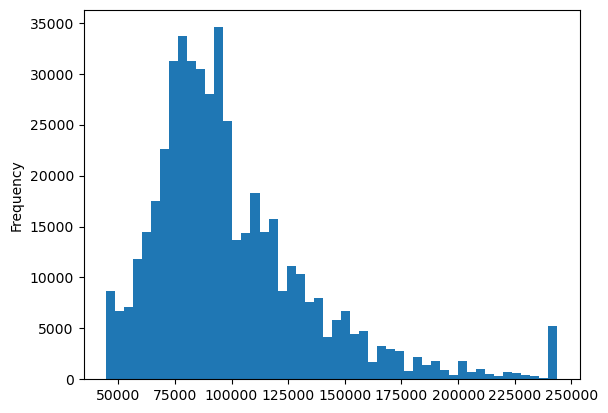

In [119]:
lca_data.loc[(lca_data.UNIT_OF_PAY == 'Year') & (lca_data.YEAR == 2019), "WAGE_RATE_FROM_W1"].plot.hist(bins=50)

<Axes: ylabel='Frequency'>

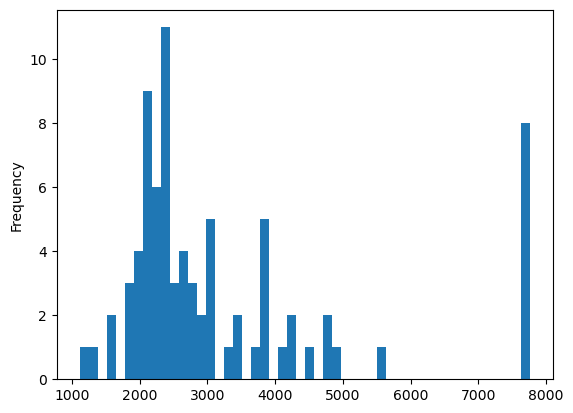

In [134]:
lca_data.loc[(lca_data.UNIT_OF_PAY == 'Bi-Weekly') & (lca_data.YEAR == 2019), "WAGE_RATE_FROM_W1"].plot.hist(bins=50)

In [142]:
lca_data.loc[(lca_data.UNIT_OF_PAY == 'Bi-Weekly') & (lca_data.YEAR == 2019)].sort_values(by="WAGE_RATE_FROM_W1", ascending=False).head(10)

,EMPLOYER_STATE,UNIT_OF_PAY,WORKSITE_STATE,EMPLOYER_POSTAL_CODE,WORKSITE_ADDRESS1,CASE_STATUS,CASE_NUMBER,EMPLOYER_NAME,NAICS_CODE,EMPLOYER_CITY,...,WAGE_RATE_FROM,WORKSITE_POSTAL_CODE,SOC_CODE,JOB_TITLE,EMPLOYER_ADDRESS,WAGE_RATE_TO,PROGRAM,YEAR,QUARTER,WAGE_RATE_FROM_W1
5289076,IL,Bi-Weekly,IDAHO,60015,151 S. PFINGSTEN ROAD,DENIED,I-200-19025-137897,"ZOOKBINDERS, INC.",3222.0,DEERFIELD,...,40000.00,60015,51-1011,MANUFACTURING AND PRODUCTION ASSISTANT,151 S. PFINGSTEN ROAD,45000.00,LCA,2019,1,40000.00
5242346,NV,Bi-Weekly,NEVADA,89014,1540 West Warm Springs Rd,DENIED,I-200-19043-569749,BAYRAMOGLU LAW OFFICES LLC,541110.0,HENDERSON,...,39853.00,89014,23-2011,PATENT AGENT/ENGINEER,1540 WEST WARM SPRINGS ROAD,NaN,LCA,2019,1,39853.00
5277922,FL,Bi-Weekly,FLORIDA,33136,9333 SW 152 Avenue,CERTIFIED,I-200-19193-388272,PUBLIC HEALTH TRUST,622110.0,MIAMI,...,12000.00,33157,29-1069,ATTENDING PHYSICIAN- ER,1611 NW 12 AVENUE,NaN,LCA,2019,3,12000.00
5271499,CA,Bi-Weekly,CALIFORNIA,95231,500 W. HOSPITAL ROAD,CERTIFIED,I-200-19092-057274,SAN JOAQUIN GENERAL HOSPITAL,622110.0,FRENCH CAMP,...,7768.25,95231,29-1063,PRIMARY CARE PHYSICIAN (INTERNAL MEDICINE),500 W. HOSPITAL ROAD,7768.25,LCA,2019,2,7768.25
5270482,CA,Bi-Weekly,CALIFORNIA,95231,500 W. HOSPITAL ROAD,CERTIFIED,I-200-19092-660672,SAN JOAQUIN GENERAL HOSPITAL,622110.0,FRENCH CAMP,...,7768.25,95231,29-1062,PRIMARY CARE PHYSICIAN (FAMILY MEDICINE/OBGYN),500 W. HOSPITAL ROAD,7768.25,LCA,2019,2,7768.25
5270618,CA,Bi-Weekly,CALIFORNIA,95231,500 W. HOSPITAL ROAD,CERTIFIED,I-200-19126-900270,SAN JOAQUIN GENERAL HOSPITAL,622110.0,FRENCH CAMP,...,7768.25,95231,29-1062,PRIMARY CARE PHYSICIAN (FAMILY MEDICINE/OBGYN),500 W. HOSPITAL ROAD,7768.25,LCA,2019,2,7768.25
5271500,CA,Bi-Weekly,CALIFORNIA,95231,500 W. HOSPITAL ROAD,CERTIFIED,I-200-19092-008130,SAN JOAQUIN GENERAL HOSPITAL,622110.0,FRENCH CAMP,...,7768.25,95231,29-1063,PRIMARY CARE PHYSICIAN (INTERNAL MEDICINE),500 W. HOSPITAL ROAD,7768.25,LCA,2019,2,7768.25
4646768,IL,Bi-Weekly,ILLINOIS,60085,3010 GRAND AVE,CERTIFIED-WITHDRAWN,I-200-19226-352702,LAKE COUNTY HEALTH DEPARTMENT & COMMUNITY HEAL...,921110.0,WAUKEGAN,...,7692.31,60085,11-9111,REGIONAL MEDICAL DIRECTOR,3010 GRAND AVENUE,7692.31,LCA,2019,3,7692.31
4646235,IL,Bi-Weekly,ILLINOIS,60085,2215 14th Street,WITHDRAWN,I-200-19233-861066,LAKE COUNTY HEALTH DEPARTMENT & COMMUNITY HEAL...,921110.0,WAUKEGAN,...,7692.31,60064,11-9111,REGIONAL MEDICAL DIRECTOR,3010 GRAND AVENUE,7692.31,LCA,2019,3,7692.31
4646774,IL,Bi-Weekly,ILLINOIS,60085,2215 14th St.,CERTIFIED,I-200-19233-526723,LAKE COUNTY HEALTH DEPARTMENT & COMMUNITY HEAL...,921110.0,WAUKEGAN,...,7692.31,60064,11-9111,REGIONAL MEDICAL DIRECTOR,3010 GRAND AVENUE,7692.31,LCA,2019,3,7692.31


In [143]:
def create_yr_wage(wage, unit_of_pay):
    if unit_of_pay == "Year":
        return wage
    elif unit_of_pay == "Month":
        return wage * 12
    elif unit_of_pay == "Week":
        return wage * 52
    elif unit_of_pay == "Bi-Weekly":
        return wage * 26
    elif unit_of_pay == "Hour":
        return wage * 40 * 52
    else:
        return np.nan
    
def create_hr_wage(wage, unit_of_pay):
    if unit_of_pay == "Year":
        return wage / (40 * 52)
    elif unit_of_pay == "Month":
        return wage / (40 * 52 / 12)
    elif unit_of_pay == "Week":
        return wage / 40
    elif unit_of_pay == "Bi-Weekly":
        return wage / 80
    elif unit_of_pay == "Hour":
        return wage
    else:
        return np.nan

lca_data["WAGE_YR"] = lca_data.apply(lambda x: create_yr_wage(x.WAGE_RATE_FROM_W1, x.UNIT_OF_PAY), axis=1)
lca_data["WAGE_HR"] = lca_data.apply(lambda x: create_hr_wage(x.WAGE_RATE_FROM_W1, x.UNIT_OF_PAY), axis=1)

In [99]:
lca_data

,EMPLOYER_STATE,UNIT_OF_PAY,WORKSITE_STATE,EMPLOYER_POSTAL_CODE,WORKSITE_ADDRESS1,CASE_STATUS,CASE_NUMBER,EMPLOYER_NAME,NAICS_CODE,EMPLOYER_CITY,...,JOB_TITLE,EMPLOYER_ADDRESS,WAGE_RATE_TO,PROGRAM,YEAR,QUARTER,WAGE_YR,WAGE_HR,Flagged,WAGE_RATE_FROM_W1
0,MD,Year,GA,21045.0,NaN,CERTIFIED-WITHDRAWN,I-200-09198-587210,XPEDITE TECHNOLOGIES INC,541511.0,COLUMBIA,...,NETWORK AND COMPUTER SYSTEMS ADMINISTRATORS,8830 STANFORD BLVD,NaN,LCA,2009,4,NaN,NaN,False,NaN
1,NJ,Year,NJ,8902.0,NaN,CERTIFIED-WITHDRAWN,I-200-09203-879743,CYBER RESOURCE GROUP INC,541511.0,NORTH BRUNSWICK,...,PROGRAMMER ANALYST,208 NORTH CENTER DRIVE,71000.0,LCA,2009,4,NaN,NaN,False,NaN
2,ID,Year,ID,83716.0,NaN,CERTIFIED-WITHDRAWN,I-200-09205-901931,"MICRON TECHNOLOGY, INC.",334413.0,BOISE,...,SALES REPORTING ANALYST,"8000 S. FEDERAL WAY, MAIL STOP 1-507",NaN,LCA,2009,4,NaN,NaN,False,NaN
3,MD,Year,MD,20892.0,NaN,CERTIFIED-WITHDRAWN,I-200-09211-683464,"NATIONAL INSTITUTES OF HEALTH, HHS",541712.0,BETHESDA,...,RESEARCH FELLOW,DIVISION OF INTERNATIONAL SERVICES/ORS,NaN,LCA,2009,4,NaN,NaN,False,NaN
4,NJ,Year,NY,8854.0,NaN,CERTIFIED-WITHDRAWN,I-200-09218-546645,"MARLABS, INC",541511.0,PISCATAWAY,...,PROGRAMMER/ANALYST,1 CORPORATE PLACE SOUTH,64000.0,LCA,2009,4,NaN,NaN,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5900785,CA,Year,CA,94107,825 E Evelyn Ave.,CERTIFIED-WITHDRAWN,I-200-23292-444332,Osaro Inc.,511210.0,San Francisco,...,Deployment Engineer,500 3rd St,152000.0,LCA,2024,3,NaN,NaN,False,NaN
5900786,TX,Year,MI,78735,28125 Cabot Drive,CERTIFIED,I-200-24176-143448,"NXP USA, INC.",334413.0,Austin,...,Automotive Embedded Linux Field Application En...,6501 W William Cannon Drive,NaN,LCA,2024,3,NaN,NaN,False,NaN
5900787,TX,Year,NC,77845,"305, Church at North Hills Street",CERTIFIED,I-200-24176-141378,COGNIZANT TECHNOLOGY SOLUTIONS US CORP,541512.0,COLLEGE STATION,...,Manager JC50 - Computer Systems Engineers/Arch...,211 QUALITY CIRCLE,NaN,LCA,2024,3,NaN,NaN,False,NaN
5900788,CO,Year,CO,80210-1503,2512 S University Blvd,CERTIFIED,I-200-24176-141827,Soona Co,541922.0,Denver,...,Data Scientist,1235 S Broadway,NaN,LCA,2024,3,NaN,NaN,False,NaN


In [146]:
# Flag potential outliers based on thresholds
lca_data['Flagged'] = (
    (lca_data['WAGE_YR'] > 2000000) | 
    (lca_data['WAGE_YR'] < 5000)
)

# View flagged rows
flagged_rows = lca_data[lca_data['Flagged']]

In [147]:
flagged_rows

,EMPLOYER_STATE,UNIT_OF_PAY,WORKSITE_STATE,EMPLOYER_POSTAL_CODE,WORKSITE_ADDRESS1,CASE_STATUS,CASE_NUMBER,EMPLOYER_NAME,NAICS_CODE,EMPLOYER_CITY,...,JOB_TITLE,EMPLOYER_ADDRESS,WAGE_RATE_TO,PROGRAM,YEAR,QUARTER,WAGE_RATE_FROM_W1,WAGE_YR,WAGE_HR,Flagged
26,NJ,Hour,NJ,8536.0,NaN,CERTIFIED,I-200-09267-513494,"SARANSH, INC.",541511.0,PLAINSBORO,...,HUMAN RESOURCES ANALYST,666 PLAINSBORO RD,NaN,LCA,2009,4,34695.000,7.216560e+07,34695.000000,True
542,CA,Hour,CA,94301.0,NaN,CERTIFIED,I-200-09259-945484,"GOODLANDS PROPERTY MANAGEMENT, LLC",531310.0,PALO ALTO,...,CHIEF OPERATIONS OFFICER,250 UNIVERSITY AVENUE,NaN,LCA,2009,4,79356.896,1.650623e+08,79356.896000,True
716,NY,Hour,NY,10018.0,NaN,CERTIFIED,I-200-09267-007102,"LIQUIDNET HOLDINGS, INC.",541614.0,NEW YORK,...,OPERATIONS RESEARCH ANALYST,498 7TH AVENUE,NaN,LCA,2009,4,79356.896,1.650623e+08,79356.896000,True
820,MI,Hour,MI,48314.0,NaN,CERTIFIED,I-200-09270-599085,MICHIGAN REHAB SERVICES PROVIDER INC.,621498.0,STERLING HEIGHTS,...,REHAB COORDINATOR,43763 VAN DYKE,NaN,LCA,2009,4,55000.000,1.144000e+08,55000.000000,True
1371,NJ,Hour,NJ,8820.0,NaN,CERTIFIED,I-200-09271-124067,"AR SYSTEMS, INC",541511.0,EDISON,...,PROGRAMMER ANALYST,"22 MERIDIAN ROAD, SUITE 18",NaN,LCA,2009,4,65000.000,1.352000e+08,65000.000000,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5707149,VA,Month,TX,24060,3711 S Mopac Expy,CERTIFIED,I-200-23233-282192,"TORC Robotics, Inc.",541330.0,Blacksburg,...,Software Engineer 3,405 Partnership Drive,NaN,LCA,2023,3,170000.000,2.040000e+06,980.769231,True
5727782,NY,Month,NV,10003,210 Quest Park St (employee home office),CERTIFIED,I-200-23220-248465,"Messari, Inc.",541511.0,New York,...,Backend Engineer (Technical Lead),228 Park Ave S,260000.0,LCA,2023,3,172760.000,2.073120e+06,996.692308,True
5740272,GA,Month,IL,30328,1401 East State Street,CERTIFIED,I-200-23209-223868,"Independent Physicians Resource, Inc.",62111.0,Atlanta,...,Hospitalist Physician,5665 New Northside Drive,NaN,LCA,2023,3,172760.000,2.073120e+06,996.692308,True
5875437,IL,Bi-Weekly,IL,60640,4401 N Ravenswood,CERTIFIED,I-200-24193-189396,Lillstreet Gallery Inc.,6116.0,Chicago,...,Director of Outreach and Artist Programs,4401 N Ravenswood,35.0,LCA,2024,3,30.000,7.800000e+02,0.375000,True


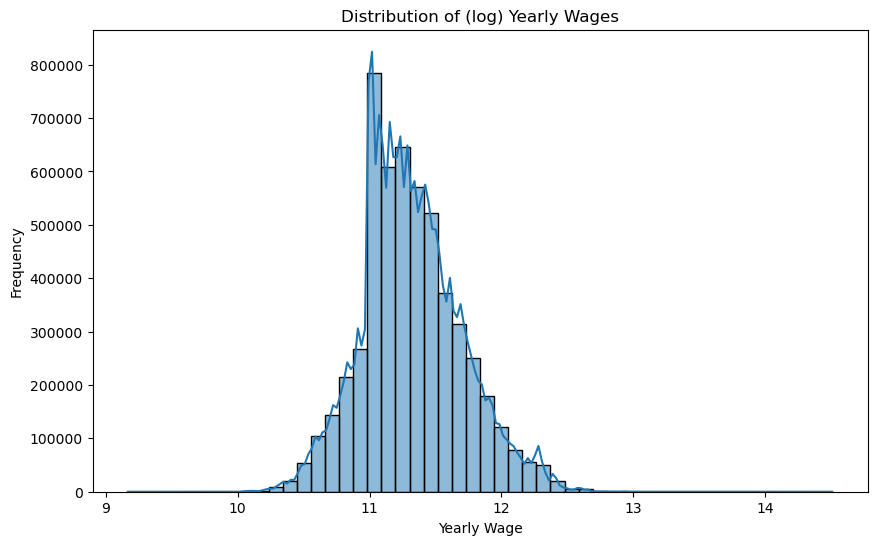

In [159]:
lca_data.loc[:, "LOG_WAGE_YR"] = np.log(lca_data.WAGE_YR)

plt.figure(figsize=(10, 6))
sns.histplot(lca_data.loc[lca_data.Flagged == False]['LOG_WAGE_YR'], bins=50, kde=True)
plt.title('Distribution of (log) Yearly Wages')
plt.xlabel('Yearly Wage')
plt.ylabel('Frequency')
plt.show()

In [153]:
lca_data.loc[lca_data.Flagged == False].CASE_STATUS.value_counts(normalize=True)    

CASE_STATUS
CERTIFIED              0.873458
CERTIFIED-WITHDRAWN    0.069274
WITHDRAWN              0.030161
DENIED                 0.027107
Name: proportion, dtype: float64

In [154]:
lca_data.loc[lca_data.Flagged].CASE_STATUS.value_counts(normalize=True)    

CASE_STATUS
DENIED                 0.481949
CERTIFIED              0.426031
WITHDRAWN              0.058225
CERTIFIED-WITHDRAWN    0.033795
Name: proportion, dtype: float64

In [158]:
# lca_data[
lca_data.EMPLOYER_NAME.str.contains("MICROSOFT")
# ]

0          False
1          False
2          False
3          False
4          False
           ...  
5900785    False
5900786    False
5900787    False
5900788    False
5900789    False
Name: EMPLOYER_NAME, Length: 5407316, dtype: object